In [1]:
"""
Use AutoEncoders for dimensionality reduction
Apply on UA-DETRAC Dataset

"""

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import h5py

import sys


from sklearn.cluster import KMeans
os.environ["CUDA_VISIBLE_DEVICES"]="0"
keras.backend.clear_session()

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

'/home/jbang36/eva/data/ua_detrac/small-data'

In [3]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    print(image_dir)
    #tmp = '/nethome/jbang36/eva/data/ua_detrac'
    mvi_dir = os.listdir(image_dir)
    mvi_dir.sort()
    
    for mvi in mvi_dir:
        if mvi == "README.md" or mvi == "download.sh" or mvi == "unzip.sh":
            continue
        image_files = os.listdir(os.path.join(image_dir, mvi))
        image_files.sort()
        for image_file in image_files:
            file_names.append(os.path.join(image_dir, mvi, image_file))
        
    print("Length of file_names", len(file_names))
    print(file_names[0])

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 12)

/home/jbang36/eva/data/ua_detrac/small-data
Length of file_names 10421
/home/jbang36/eva/data/ua_detrac/small-data/MVI_20011/img00001.jpg


In [4]:
# split the training and test data

n_samples = image_table.shape[0]
train_x = image_table[:int(n_samples * 0.8)]
test_x = image_table[int(n_samples * 0.8):]

(45, 80)


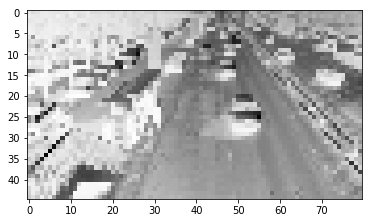

In [5]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

plt.imshow(train_x[image_index], cmap='Greys')

In [6]:
n_samples, width, height = image_table.shape

# Must perform normalization for the autoencoder to perform well
train_x /= 255.0
test_x /= 255.0 

In [ ]:
keras.backend.clear_session()

In [7]:
# autoencoder network with only FC layers
input_img = Input(shape=(width,height))

encoded = Flatten()(input_img)

# "encoded" is the encoded representation of the input
encoded = Dense(width*height // 4, activation='relu')(encoded)
encoded = Dense(width*height // 16, activation='relu')(encoded)
encoded = Dense(width*height // 64, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(width*height // 16, activation='relu')(encoded)
decoded = Dense(width*height // 4, activation='relu')(decoded)
decoded = Dense(width*height, activation = 'relu')(decoded)
decoded = Reshape((width, height))(decoded)
    

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

autoencoder.summary()

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 900)               3240900   
_________________________________________________________________
dense_2 (Dense)              (None, 225)               202725    
_________________________________________________________________
dense_3 (Dense)              (None, 56)                12656     
_________________________________________________________________
dense_4 (Dense)              (None, 225)               12825     
_________________________________________________________________
dense_5 (Dense)              (None, 900)               203400    
__________

In [8]:
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Train on 8336 samples, validate on 2085 samples
Epoch 1/200
8336/8336 [==============================] - 3s 334us/step - loss: 0.1577 - val_loss: 0.1028
Epoch 2/200
8336/8336 [==============================] - 1s 116us/step - loss: 0.0965 - val_loss: 0.0863
Epoch 3/200
8336/8336 [==============================] - 1s 115us/step - loss: 0.0825 - val_loss: 0.0805
Epoch 4/200
8336/8336 [==============================] - 1s 111us/step - loss: 0.0778 - val_loss: 0.0777
Epoch 5/200
8336/8336 [==============================] - 1s 113us/step - loss: 0.0755 - val_loss: 0.0761
Epoch 6/200
8336/8336 [==============================] - 1s 106us/step - loss: 0.0743 - val_loss: 0.0753
Epoch 7/200
8336/8336 [==============================] - 1s 105us/step - loss: 0.0736 - val_loss: 0.0745
Epoch 8/200
8336/8336 [==============================] - 1s 110us/step - loss: 0.0729 - val_loss: 0.0744
Epoch 9/200
8336/8336 [==============================] - 1s 119us/step - loss: 0.0725 - val_loss: 0.0740
Epoch 1

Epoch 78/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0221 - val_loss: 0.0281
Epoch 79/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0209 - val_loss: 0.0278
Epoch 80/200
8336/8336 [==============================] - 1s 113us/step - loss: 0.0199 - val_loss: 0.0264
Epoch 81/200
8336/8336 [==============================] - 1s 112us/step - loss: 0.0191 - val_loss: 0.0262
Epoch 82/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0185 - val_loss: 0.0263
Epoch 83/200
8336/8336 [==============================] - 1s 151us/step - loss: 0.0183 - val_loss: 0.0258
Epoch 84/200
8336/8336 [==============================] - 1s 118us/step - loss: 0.0180 - val_loss: 0.0256
Epoch 85/200
8336/8336 [==============================] - 1s 112us/step - loss: 0.0177 - val_loss: 0.0253
Epoch 86/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0175 - val_loss: 0.0254
Epoch 87/200
8336/8336 [======================

Epoch 155/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0095 - val_loss: 0.0189
Epoch 156/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0094 - val_loss: 0.0190
Epoch 157/200
8336/8336 [==============================] - 1s 119us/step - loss: 0.0095 - val_loss: 0.0188
Epoch 158/200
8336/8336 [==============================] - 1s 113us/step - loss: 0.0094 - val_loss: 0.0189
Epoch 159/200
8336/8336 [==============================] - 1s 113us/step - loss: 0.0092 - val_loss: 0.0189
Epoch 160/200
8336/8336 [==============================] - 1s 114us/step - loss: 0.0092 - val_loss: 0.0185
Epoch 161/200
8336/8336 [==============================] - 1s 119us/step - loss: 0.0093 - val_loss: 0.0191
Epoch 162/200
8336/8336 [==============================] - 1s 100us/step - loss: 0.0092 - val_loss: 0.0188
Epoch 163/200
8336/8336 [==============================] - 1s 118us/step - loss: 0.0092 - val_loss: 0.0186
Epoch 164/200
8336/8336 [============

In [9]:
# After downsizing the images, we need to cluster them by similarity
# Heuristic we will use is to assume fps rate is 20. We will make num_samples / 20 clusters

# Apply hierarchical clustering
# Remember the indexes
# Put the images into correct locations
# TODO: Currently the images are not being divided correctly... We need to find out why

from sklearn.cluster import AgglomerativeClustering

n_samples, width, height = image_table.shape
#image_table_flattened = image_table.reshape(-1, width*height).astype('float32')


auto_encoded_train = encoder.predict(train_x)
auto_encoded_test = encoder.predict(test_x)

train_decoded = autoencoder.predict(train_x)
test_decoded = autoencoder.predict(test_x)

images_compressed = encoder.predict(image_table)

fps = 20
ac = AgglomerativeClustering(n_clusters=len(images_compressed) // fps)

start_time = time.time()
ac.fit(images_compressed)
print("Time to fit ", n_samples, ": ", time.time() - start_time)
images_label = ac.labels_

print(min(images_label))
print(max(images_label))



[[1.9181751  0.         0.         0.9502051  2.5478427  0.
  0.         0.         0.         1.4459057  2.7659113  0.
  0.10943673 1.1406857  3.600594   0.         0.         0.
  4.4435306  2.213328   1.7115382  0.         0.         0.
  2.2040427  0.         0.5479278  0.         0.         0.
  0.         1.8753015  0.         1.9844187  0.1243341  2.3990471
  2.5828266  0.0892084  0.         2.3610218  0.         2.13451
  1.5057099  0.         0.         1.9399858  1.5298594  0.30155265
  0.         0.         0.3991761  0.         0.         0.
  0.         0.        ]
 [1.990215   0.         0.         0.99552083 2.446505   0.
  0.         0.         0.         1.4919572  2.7474697  0.
  0.11335108 1.154121   3.5985174  0.         0.         0.
  4.4158063  2.2180903  1.8395818  0.         0.         0.
  2.14966    0.         0.49583158 0.         0.         0.
  0.         1.8909632  0.         1.9616418  0.17968388 2.5060346
  2.6354244  0.         0.         2.3324912  0.

[[ 73.  56.  64. ... 116. 153. 183.]
 [ 49.  65.  58. ...  85. 104.  90.]
 [ 52.  54.  55. ... 123. 135. 111.]
 ...
 [111. 128. 123. ... 141. 148. 152.]
 [121. 122. 130. ... 128. 144. 149.]
 [117. 118. 115. ... 124. 143. 144.]]
0
(45, 80)
[[ 68.  87.  76. ... 142. 139. 150.]
 [ 64.  64.  74. ... 119. 140. 123.]
 [ 65.  74.  73. ... 120. 139. 127.]
 ...
 [ 87.  86.  68. ... 116. 155. 158.]
 [ 90.  98.  70. ... 142. 148. 153.]
 [138. 106.  96. ... 142. 144. 139.]]
2
(45, 80)
[[ 67.  75.  66. ... 127. 113. 123.]
 [ 75.  75.  60. ... 124. 177. 185.]
 [ 67.  61.  67. ... 105. 161. 170.]
 ...
 [117. 112.  86. ... 110. 140. 158.]
 [112. 152. 104. ... 150. 151. 143.]
 [ 87.  67. 122. ... 145. 112. 137.]]
4
(45, 80)


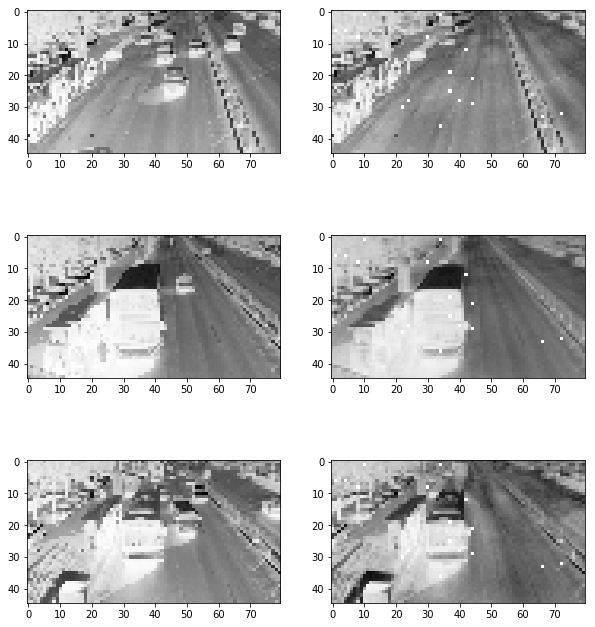

In [10]:
# Let's display the original image and the decoded image side by side
# We will randomly draw 5 images

import matplotlib.pyplot as plt
import random
n_samples, width, height = image_table.shape

fig=plt.figure(figsize=(10, 20))
columns = 2
rows = 5

for idx in range(0, rows, 2):
    fig.add_subplot(rows, columns, idx + 1)
    #a = cv2.imread(image)
    random_index = random.randint(0, len(train_decoded))
    original = np.copy(train_x[random_index])
    original *= 255.0
    print(original)
    original = original.astype('int32')
    print(idx)
    #print(original)
    print(original.shape)
    
    plt.imshow(original, cmap='Greys')
    fig.add_subplot(rows, columns, idx + 2)
    decoded = np.copy(train_decoded[random_index])
    decoded *= 255.0
    decoded = decoded.astype('int32')
    decoded = decoded.reshape(width, height)
    plt.imshow(decoded, cmap='Greys')
    
plt.show()

Text(0, 0.5, 'Number of datapoints')

/nethome/jbang36/anaconda3/envs/jb_py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


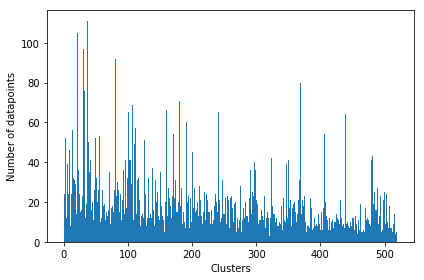

In [27]:

# I think it is best to see the distributions

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(images_label, bins=max(images_label) + 1)
plt.xlabel("Clusters")
plt.ylabel("Number of datapoints")

In [28]:
images_label[:300]

array([189, 189, 189, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 189, 189, 189, 189, 189, 189, 189, 189, 189,
       189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189,
       200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 200, 200, 189, 189, 189, 189, 189, 189, 189,
       287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287,
       287, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345,
       345, 345, 345, 345, 345, 345, 345, 345, 345, 412, 412, 412, 412,
       412, 412, 412, 412, 412, 412, 412, 412, 280, 280, 280, 280, 280,
       280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 355,
       355, 355, 355, 355, 355, 355, 355, 408, 408, 408, 408, 408, 408,
       408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 40

In [34]:
# Copy original data to the new clusters

from shutil import copyfile

os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')

mvi_folders = os.listdir(data_dir)
print(mvi_folders)
mvi_folders.sort()

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-clusters')
    
total_cluster_count = 0    
offset = 0
for i in range(len(mvi_folders)):
    image_files = os.listdir(os.path.join(data_dir, mvi_folders[i]))
    image_files.sort()
    print("length of image_files in directory", mvi_folders[i], "is ", len(image_files))
    for j in range(len(image_files)):
        src = os.path.join(data_dir, mvi_folders[i], image_files[j])
        
        cluster_dir = os.path.join(cluster_dir_pre, str(images_label[offset+j]))
        dst = os.path.join(cluster_dir, image_files[j])
        if not os.path.exists(cluster_dir):
            os.mkdir(cluster_dir)
            total_cluster_count += 1
        #print(src)
        #print(dst)
        copyfile(src, dst)
        
    offset += len(image_files)

print("Done copying all files")
print("Number of clusters made:", total_cluster_count)
        

['MVI_20064', 'MVI_20062', 'MVI_20032', 'MVI_20011', 'MVI_20051', 'MVI_20034', 'MVI_20033', 'MVI_20012', 'MVI_20061', 'MVI_20065', 'MVI_20052', 'MVI_20063', 'MVI_20035']
length of image_files in directory MVI_20011 is  664
length of image_files in directory MVI_20012 is  936
length of image_files in directory MVI_20032 is  437
length of image_files in directory MVI_20033 is  784
length of image_files in directory MVI_20034 is  800
length of image_files in directory MVI_20035 is  800
length of image_files in directory MVI_20051 is  906
length of image_files in directory MVI_20052 is  694
length of image_files in directory MVI_20061 is  800
length of image_files in directory MVI_20062 is  800
length of image_files in directory MVI_20063 is  800
length of image_files in directory MVI_20064 is  800
length of image_files in directory MVI_20065 is  1200
Done copying all files
Number of clusters made: 521


length of heterogeneous labels 521
520
0
111
3


Text(0, 0.5, 'Number of datapoints')

/nethome/jbang36/anaconda3/envs/jb_py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


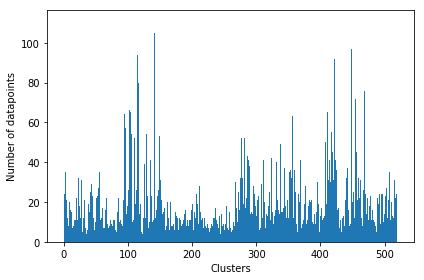

In [32]:
# Do some more analysis on the distribution of numbers
# Possible questions could be: How many examples are there per cluster?
# It is really cool that the algorithm actually uses 74 clusters (numbers 0 - 72)

#TODO: We have to analyze the results
"""
Things to analyze:
0. Reorganize the labels from 0 - 74
1. Are the shots contiguous? - reorder, extract the number, - Not Necessarily
2. What is the distribution? - how many frames per grouping?
"""

final_labels = [] # Just use the indexes
final_counts = []
converted_images_label = []
for idx, image_label in enumerate(images_label):
    if image_label not in final_labels:
        final_labels.append(image_label)
        final_counts.append(1)
        converted_images_label.append(len(final_labels) - 1)
    else:
        index = final_labels.index(image_label)
        final_counts[index] += 1
        converted_images_label.append(index)
        
assert(len(final_labels) == len(final_counts))
print("length of heterogeneous labels", len(final_labels))

print(max(images_label))
print(min(images_label))
print(max(final_counts))
print(min(final_counts))

# 2. What is the distribution?
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(converted_images_label, bins=len(final_counts))
plt.xlabel("Clusters")
plt.ylabel("Number of datapoints")
        


15


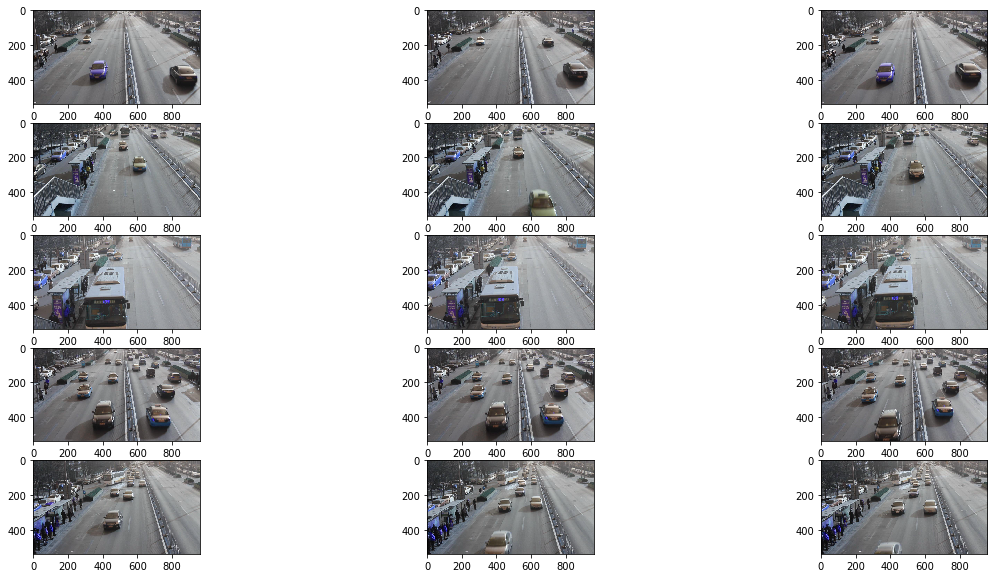

In [35]:
# UTIL: Plot the images that belong in the same cluster and different clusters
# We will select 3 from each directory

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-clusters')
cluster_nums = os.listdir(cluster_dir_pre)

# I would love to display all the clusters but for now let's just pick 10


full_paths = []
for i in range(5):
    cluster_dir = os.path.join(cluster_dir_pre, str(cluster_nums[i]))
    image_files = os.listdir(cluster_dir)
    for j in range(3):
        full_paths.append(os.path.join(cluster_dir, image_files[j]))

        
print(len(full_paths))
import matplotlib.pyplot as plt


fig=plt.figure(figsize=(20, 10))
columns = 3
rows = 5

for idx, image in enumerate(full_paths):
    fig.add_subplot(rows, columns, idx + 1)
    a = cv2.imread(image)
    plt.imshow(a)
plt.show()
    

In [ ]:
# UTIL: Remove all the clusters and its data

cluster_dir_pre = os.path.join(home_dir, 'data', 'ua_detrac', 'tiny-clusters')
cluster_max = max(images_label)


for i in range(cluster_max + 1):
    cluster_dir = os.path.join(cluster_dir_pre, str(i))
    if os.path.exists(cluster_dir):
        shutil.rmtree(cluster_dir)
        